In [2]:
###########################################
# IMPORTING REQUIREMENTS
###########################################

from langchain_aws import ChatBedrockConverse
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AIMessageChunk, BaseMessage
import boto3
from dotenv import load_dotenv, find_dotenv
import os
from langgraph.graph import StateGraph, add_messages
from langgraph.constants import START, END
from typing import Annotated, TypedDict
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
###########################################
# LOADING ENV Variables
###########################################
load_dotenv(find_dotenv())

True

In [3]:
###########################################
# === AWS Configuration === #
###########################################
COGNITO_REGION = os.getenv("COGNITO_REGION")
BEDROCK_REGION = os.getenv("BEDROCK_REGION")
MODEL_ID1 = os.getenv("MODEL_ID1")
MODEL_ID2 = os.getenv("MODEL_ID2")
IDENTITY_POOL_ID = os.getenv("IDENTITY_POOL_ID")
USER_POOL_ID = os.getenv("USER_POOL_ID")
APP_CLIENT_ID = os.getenv("APP_CLIENT_ID")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")

In [4]:
###########################################
# === Helper: Get AWS Credentials === #
###########################################
def get_credentials(username, password):
    idp_client = boto3.client("cognito-idp", region_name=COGNITO_REGION)
    response = idp_client.initiate_auth(
        AuthFlow="USER_PASSWORD_AUTH",
        AuthParameters={"USERNAME": username, "PASSWORD": password},
        ClientId=APP_CLIENT_ID,
    )
    id_token = response["AuthenticationResult"]["IdToken"]

    identity_client = boto3.client("cognito-identity", region_name=COGNITO_REGION)
    identity_response = identity_client.get_id(
        IdentityPoolId=IDENTITY_POOL_ID,
        Logins={f"cognito-idp.{COGNITO_REGION}.amazonaws.com/{USER_POOL_ID}": id_token},
    )

    creds_response = identity_client.get_credentials_for_identity(
        IdentityId=identity_response["IdentityId"],
        Logins={f"cognito-idp.{COGNITO_REGION}.amazonaws.com/{USER_POOL_ID}": id_token},
    )

    return creds_response["Credentials"]

### v1 Basic Memory-less Chatbot

In [5]:
###########################################
# Defining Chat Schema
###########################################
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [6]:
###########################################
# Defining Node Logic
###########################################
def chat_node(state: ChatState):
    """
    LLM node that may answer or request a tool call
    """
    credentials = get_credentials(USERNAME, PASSWORD)
    os.environ["AWS_ACCESS_KEY_ID"] = credentials["AccessKeyId"]
    os.environ["AWS_SECRET_ACCESS_KEY"] = credentials["SecretKey"]
    os.environ["AWS_SESSION_TOKEN"] = credentials["SessionToken"]

    llm = ChatBedrockConverse(
        model_id=MODEL_ID1,
        region_name=BEDROCK_REGION,
        max_tokens=2500,
        temperature=0.2,
    )

    messages = state['messages']
    response = llm.invoke(messages)

    return {'messages': [response]}

In [7]:
###########################################
# Creating Workflow
###########################################
graph = StateGraph(ChatState)

graph.add_node(node='chat_node', action=chat_node)


graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile()

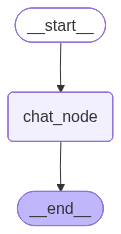

In [8]:
chatbot

In [13]:
chatbot.invoke({"messages":['Hi']})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='6b2a3176-f4d8-4908-bce1-3d6f35395141'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'c9fc015a-dbe3-406b-a4c2-6c9eb775240e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 02 Nov 2025 09:51:06 GMT', 'content-type': 'application/json', 'content-length': '233', 'connection': 'keep-alive', 'x-amzn-requestid': 'c9fc015a-dbe3-406b-a4c2-6c9eb775240e'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [627]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--2975eb82-0fe7-45cd-87d9-42b7063d0ab5-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})]}

In [14]:
chatbot.invoke({"messages":['Hi']}).get('messages')[-1].text

'Hello! How can I help you today?'

In [24]:
for chunk in chatbot.stream({"messages":['Hi']}, stream_mode="updates"):
    for step, data in chunk.items():
        print(step)
        print(data['messages'][-1].content_blocks)
        print("-"*50)
    

chat_node
[{'type': 'text', 'text': 'Hello! How can I help you today?'}]
--------------------------------------------------


In [29]:
for token, metadata in chatbot.stream({"messages":['Hi']}, stream_mode="messages"):
    print(token.content_blocks)
    print(metadata)
    print('-'*50)

[]
{'langgraph_step': 1, 'langgraph_node': 'chat_node', 'langgraph_triggers': ('branch:to:chat_node',), 'langgraph_path': ('__pregel_pull', 'chat_node'), 'langgraph_checkpoint_ns': 'chat_node:f9113e1b-6f56-f6cf-10ce-4367e573302e', 'checkpoint_ns': 'chat_node:f9113e1b-6f56-f6cf-10ce-4367e573302e', 'ls_provider': 'amazon_bedrock', 'ls_model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'ls_model_type': 'chat', 'ls_temperature': 0.2, 'ls_max_tokens': 2500}
--------------------------------------------------
[{'type': 'text', 'text': 'Hello', 'index': 0}]
{'langgraph_step': 1, 'langgraph_node': 'chat_node', 'langgraph_triggers': ('branch:to:chat_node',), 'langgraph_path': ('__pregel_pull', 'chat_node'), 'langgraph_checkpoint_ns': 'chat_node:f9113e1b-6f56-f6cf-10ce-4367e573302e', 'checkpoint_ns': 'chat_node:f9113e1b-6f56-f6cf-10ce-4367e573302e', 'ls_provider': 'amazon_bedrock', 'ls_model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'ls_model_type': 'chat', 'ls_temperature': 0.2,

In [30]:
for chunk in chatbot.stream({"messages":['Hi']}, stream_mode="messages"):
    print(chunk)

(AIMessageChunk(content=[], additional_kwargs={}, response_metadata={'model_provider': 'bedrock_converse'}, id='lc_run--a5441aee-20da-47ba-9597-211bf423c793'), {'langgraph_step': 1, 'langgraph_node': 'chat_node', 'langgraph_triggers': ('branch:to:chat_node',), 'langgraph_path': ('__pregel_pull', 'chat_node'), 'langgraph_checkpoint_ns': 'chat_node:b5f17ec3-456d-059d-d5c9-e1f40755fd41', 'checkpoint_ns': 'chat_node:b5f17ec3-456d-059d-d5c9-e1f40755fd41', 'ls_provider': 'amazon_bedrock', 'ls_model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'ls_model_type': 'chat', 'ls_temperature': 0.2, 'ls_max_tokens': 2500})
(AIMessageChunk(content=[{'type': 'text', 'text': 'Hello', 'index': 0}], additional_kwargs={}, response_metadata={'model_provider': 'bedrock_converse'}, id='lc_run--a5441aee-20da-47ba-9597-211bf423c793'), {'langgraph_step': 1, 'langgraph_node': 'chat_node', 'langgraph_triggers': ('branch:to:chat_node',), 'langgraph_path': ('__pregel_pull', 'chat_node'), 'langgraph_checkpoint_

In [32]:
for chunk in chatbot.stream({"messages":['Hi']}, stream_mode="messages"):
    print(chunk[0].text, end='', flush=True)

Hello! How can I help you today?

In [37]:
for token,_ in chatbot.stream({"messages":['Hi']}, stream_mode="messages"):
    print(token)

content=[] additional_kwargs={} response_metadata={'model_provider': 'bedrock_converse'} id='lc_run--d669a2c1-6b53-44dd-b2f9-af3db8de3166'
content=[{'type': 'text', 'text': 'Hello', 'index': 0}] additional_kwargs={} response_metadata={'model_provider': 'bedrock_converse'} id='lc_run--d669a2c1-6b53-44dd-b2f9-af3db8de3166'
content=[{'type': 'text', 'text': '! How can', 'index': 0}] additional_kwargs={} response_metadata={'model_provider': 'bedrock_converse'} id='lc_run--d669a2c1-6b53-44dd-b2f9-af3db8de3166'
content=[{'type': 'text', 'text': ' I help', 'index': 0}] additional_kwargs={} response_metadata={'model_provider': 'bedrock_converse'} id='lc_run--d669a2c1-6b53-44dd-b2f9-af3db8de3166'
content=[{'type': 'text', 'text': ' you today?', 'index': 0}] additional_kwargs={} response_metadata={'model_provider': 'bedrock_converse'} id='lc_run--d669a2c1-6b53-44dd-b2f9-af3db8de3166'
content=[] additional_kwargs={} response_metadata={'model_provider': 'bedrock_converse'} id='lc_run--d669a2c1-6b5

In [31]:
while True:

    user_input = input("You: ")
    print(f"You: {user_input}")

    if not user_input.strip():
        continue

    if user_input.strip().lower() == "bye":
        break

    response = chatbot.invoke({"messages": [HumanMessage(content=user_input)]})

    print(f"Assistant: {response.get("messages")[-1].text}")

You: Hi
Assistant: Hello! How can I help you today?
You: my name is sai
Assistant: Hello Sai! Nice to meet you. How can I help you today?
You: what is my name
Assistant: I don't know your name unless you tell me. Each conversation with me starts fresh, so I don't have access to any previous conversations or personal information about you.
You: bye


### v2 Basic Chatbot with In-Memory Persistence

In [5]:
###########################################
# Defining Chat Schema
###########################################
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [6]:
###########################################
# Defining Node Logic
###########################################
def chat_node(state: ChatState):
    """
    LLM node that may answer or request a tool call
    """
    credentials = get_credentials(USERNAME, PASSWORD)
    os.environ["AWS_ACCESS_KEY_ID"] = credentials["AccessKeyId"]
    os.environ["AWS_SECRET_ACCESS_KEY"] = credentials["SecretKey"]
    os.environ["AWS_SESSION_TOKEN"] = credentials["SessionToken"]

    llm = ChatBedrockConverse(
        model_id=MODEL_ID1,
        region_name=BEDROCK_REGION,
        max_tokens=2500,
        temperature=0.2,
    )

    messages = state['messages']
    response = llm.invoke(messages)

    return {'messages': [response]}

In [7]:
###########################################
# Creating Workflow
###########################################
checkpointer = InMemorySaver()
graph = StateGraph(ChatState)

graph.add_node(node='chat_node', action=chat_node)


graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer) ## for persistence

In [12]:
thread_id = '1' ## for persistencew --> change tread_id to maintain convo history for multiple chats 

while True:

    user_input = input("You: ")
    print(f"You: {user_input}")

    if not user_input.strip():
        continue

    if user_input.strip().lower() == "bye":
        break


    CONFIG = {"configurable":{"thread_id":thread_id}}
    response = chatbot.invoke({"messages": [HumanMessage(content=user_input)]}, config=CONFIG)

    print(f"Assistant: {response.get("messages")[-1].text}")

You: do you remember my name still?
Assistant: Yes, I remember your name is Sai. I can remember information from our current conversation.
You: bye


In [9]:
all_threads = set()

In [10]:
for checkpoint in checkpointer.list(None):
        all_threads.add(checkpoint.config['configurable']['thread_id'])

In [11]:
list(all_threads)

[]

In [13]:
list(chatbot.get_state_history(config={"configurable":{"thread_id":"1"}}))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='cdc4b7e4-7c99-459a-b052-cc02a170a4e2'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'b36692f7-bd41-42d2-bbfb-8f4a4bedbcce', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 03 Nov 2025 17:31:50 GMT', 'content-type': 'application/json', 'content-length': '233', 'connection': 'keep-alive', 'x-amzn-requestid': 'b36692f7-bd41-42d2-bbfb-8f4a4bedbcce'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [549]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--22736935-48d1-4b6f-9def-727381559651-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='my name is sai', additional_kwargs={}, response_metadata

In [14]:
list(chatbot.get_state_history(config={"configurable":{"thread_id":"1"}}))[-1].next

('__start__',)

- If we restart the notebook, the memory which is stored in RAM will be lost, so will the chatbot's memory.

In [ ]:
chatbot.get_state(config=CONFIG) # final state

StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='dac35f15-af58-430b-8fe5-0ed01a42b99b'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '1138ccf0-a9e1-4cd3-a8bc-ae41dc6b66e0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 02 Nov 2025 10:26:32 GMT', 'content-type': 'application/json', 'content-length': '233', 'connection': 'keep-alive', 'x-amzn-requestid': '1138ccf0-a9e1-4cd3-a8bc-ae41dc6b66e0'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [510]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--365f6bd9-f24c-48cb-b4a0-8d8f46a3a76a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='my name is sai', additional_kwargs={}, response_metadata=

In [41]:
for state_snapshot in chatbot.get_state_history(config=CONFIG):
    print(state_snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='dac35f15-af58-430b-8fe5-0ed01a42b99b'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '1138ccf0-a9e1-4cd3-a8bc-ae41dc6b66e0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 02 Nov 2025 10:26:32 GMT', 'content-type': 'application/json', 'content-length': '233', 'connection': 'keep-alive', 'x-amzn-requestid': '1138ccf0-a9e1-4cd3-a8bc-ae41dc6b66e0'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [510]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--365f6bd9-f24c-48cb-b4a0-8d8f46a3a76a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='my name is sai', additional_kwargs={}, response_metadata=

- most resent snapshot at the top of the list i.e. the final snapshot

In [42]:
chatbot.get_state(config=CONFIG) == list(chatbot.get_state_history(config=CONFIG))[0]

True

### Experimenting with add_messages reducer - new message has the same ID as an existing message.

In [19]:
###########################################
# Defining Chat Schema
###########################################
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [20]:
###########################################
# Defining Node Logic
###########################################
def chat_node(state: ChatState):
    """
    LLM node that may answer or request a tool call
    """
    credentials = get_credentials(USERNAME, PASSWORD)
    os.environ["AWS_ACCESS_KEY_ID"] = credentials["AccessKeyId"]
    os.environ["AWS_SECRET_ACCESS_KEY"] = credentials["SecretKey"]
    os.environ["AWS_SESSION_TOKEN"] = credentials["SessionToken"]

    llm = ChatBedrockConverse(
        model_id=MODEL_ID1,
        region_name=BEDROCK_REGION,
        max_tokens=2500,
        temperature=0.2,
    )

    messages = state['messages']
    response = llm.invoke(messages)

    return {'messages': [response]}

In [21]:
###########################################
# Creating Workflow
###########################################
checkpointer = InMemorySaver()
graph = StateGraph(ChatState)

graph.add_node(node='chat_node', action=chat_node)


graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer) ## for persistence

In [35]:
thread_id = '3' ## for persistencew --> change tread_id to maintain convo history for multiple chats 

CONFIG = {"configurable":{"thread_id":thread_id}}
# response = chatbot.invoke({"messages": [HumanMessage(content='Hey')]}, config=CONFIG)
response = chatbot.invoke({"messages": [HumanMessage(content='Hello',id="4dcd5da9-b81e-4ff8-b833-09612442e0a6")]}, config=CONFIG)

print(f"Assistant: {response.get("messages")[-1].text}")

Assistant: 


##### Before

In [33]:
chatbot.get_state(config=CONFIG)

StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='4dcd5da9-b81e-4ff8-b833-09612442e0a6'), AIMessage(content='Hi! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '2acb2dab-661b-4b62-a306-2ab572ddae77', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 03 Nov 2025 18:42:03 GMT', 'content-type': 'application/json', 'content-length': '230', 'connection': 'keep-alive', 'x-amzn-requestid': '2acb2dab-661b-4b62-a306-2ab572ddae77'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [479]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--6cdc5d1f-8584-468e-8896-f9ec198e097a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'check

In [34]:
list(chatbot.get_state_history(config=CONFIG))

[StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='4dcd5da9-b81e-4ff8-b833-09612442e0a6'), AIMessage(content='Hi! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '2acb2dab-661b-4b62-a306-2ab572ddae77', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 03 Nov 2025 18:42:03 GMT', 'content-type': 'application/json', 'content-length': '230', 'connection': 'keep-alive', 'x-amzn-requestid': '2acb2dab-661b-4b62-a306-2ab572ddae77'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [479]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--6cdc5d1f-8584-468e-8896-f9ec198e097a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'chec

##### After

In [36]:
chatbot.get_state(config=CONFIG)

StateSnapshot(values={'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='4dcd5da9-b81e-4ff8-b833-09612442e0a6'), AIMessage(content='Hi! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '2acb2dab-661b-4b62-a306-2ab572ddae77', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 03 Nov 2025 18:42:03 GMT', 'content-type': 'application/json', 'content-length': '230', 'connection': 'keep-alive', 'x-amzn-requestid': '2acb2dab-661b-4b62-a306-2ab572ddae77'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [479]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--6cdc5d1f-8584-468e-8896-f9ec198e097a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), AIMessage(content=[], additional_kwargs={}, response_metadata={'ResponseMetadat

In [38]:
list(chatbot.get_state_history(config=CONFIG))[0:3]

[StateSnapshot(values={'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='4dcd5da9-b81e-4ff8-b833-09612442e0a6'), AIMessage(content='Hi! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '2acb2dab-661b-4b62-a306-2ab572ddae77', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 03 Nov 2025 18:42:03 GMT', 'content-type': 'application/json', 'content-length': '230', 'connection': 'keep-alive', 'x-amzn-requestid': '2acb2dab-661b-4b62-a306-2ab572ddae77'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [479]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--6cdc5d1f-8584-468e-8896-f9ec198e097a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), AIMessage(content=[], additional_kwargs={}, response_metadata={'ResponseMetada

In [39]:
list(chatbot.get_state_history(config=CONFIG))[-3:]

[StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='4dcd5da9-b81e-4ff8-b833-09612442e0a6'), AIMessage(content='Hi! How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '2acb2dab-661b-4b62-a306-2ab572ddae77', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 03 Nov 2025 18:42:03 GMT', 'content-type': 'application/json', 'content-length': '230', 'connection': 'keep-alive', 'x-amzn-requestid': '2acb2dab-661b-4b62-a306-2ab572ddae77'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [479]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--6cdc5d1f-8584-468e-8896-f9ec198e097a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'chec

### Custom reducer

In [ ]:
# initially used add_messages reducer with update_state (thread_id and checkpoint_id) aka time travel concept in LangGraph but it just kept adding the edited messaged and created "branches" and also instead of rewriting history altogether. The llm could remember the previous original messages also. The below code with custom reducers help properly implement editing previous message functionality. Now it will still create a new "branch" and but the ground truth is different. 

In [5]:
def custom_reducer(left, right):

    if isinstance(right,dict) and right.get('op') == 'edit_last_msg':

        updated_text = right.get('text')
        
        prune_idx = None
        for i in range(len(left)-1,-1,-1):
            if not isinstance(left[i], HumanMessage):
                prune_idx = i
            else:
                left[i] = HumanMessage(content=updated_text)
                return left[:i+1]
    
    if isinstance(right, dict) and right.get('op') == 'del':
        
        pop_num = right.get('n', None)

        if pop_num and pop_num <= len(left):
            return left[:-pop_num]
        
        if pop_num and pop_num > len(left):
            return []
        
        if pop_num is None:
            return []
            
    
    return add_messages(left, right)

In [6]:
###########################################
# Defining Chat Schema
###########################################
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], custom_reducer]

In [7]:
###########################################
# Defining Node Logic
###########################################
def chat_node(state: ChatState):
    """
    LLM node that may answer or request a tool call
    """
    credentials = get_credentials(USERNAME, PASSWORD)
    os.environ["AWS_ACCESS_KEY_ID"] = credentials["AccessKeyId"]
    os.environ["AWS_SECRET_ACCESS_KEY"] = credentials["SecretKey"]
    os.environ["AWS_SESSION_TOKEN"] = credentials["SessionToken"]

    llm = ChatBedrockConverse(
        model_id=MODEL_ID1,
        region_name=BEDROCK_REGION,
        max_tokens=2500,
        temperature=0.2,
    )

    messages = state['messages']
    response = llm.invoke(messages)

    return {'messages': [response]}

In [8]:
###########################################
# Creating Workflow
###########################################
checkpointer = InMemorySaver()
graph = StateGraph(ChatState)

graph.add_node(node='chat_node', action=chat_node)


graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer) ## for persistence

In [29]:
thread_id = '11' ## for persistencew --> change tread_id to maintain convo history for multiple chats 

CONFIG = {"configurable":{"thread_id":thread_id}}
# response = chatbot.invoke({"messages": [HumanMessage(content='Hey'), HumanMessage(content='my name is sai')]}, config=CONFIG)
# response = chatbot.invoke({"messages": {'op':'edit_last_msg','text':'my name is sam'}}, config=CONFIG)
# response = chatbot.invoke({"messages": [HumanMessage(content='do you remember sai? I mentioned him just before')]}, config=CONFIG)
chatbot.update_state(config=CONFIG, values={"messages":{"op":"del"}})
response = chatbot.invoke({"messages": [HumanMessage(content='I have already introduced myself right?')]}, config=CONFIG)



print(f"Assistant: {response.get("messages")[-1].text}")

Assistant: I don't have access to previous conversations with you. Each interaction with me starts fresh, as I don't maintain memory of past chats. So no, you haven't introduced yourself in our current conversation. Would you like to introduce yourself now?


In [22]:
chatbot.get_state(config=CONFIG)

StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='96814be8-5f0e-4614-85a3-c4df1a6c360a'), HumanMessage(content='my name is sai', additional_kwargs={}, response_metadata={}, id='6842a10e-8e78-4b9c-ba50-e67b88793d22'), AIMessage(content='Hi Sai! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'c363a688-32cd-4328-a29e-501d067602d9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 05 Nov 2025 08:04:28 GMT', 'content-type': 'application/json', 'content-length': '253', 'connection': 'keep-alive', 'x-amzn-requestid': 'c363a688-32cd-4328-a29e-501d067602d9'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [804]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--3d0c05e4-01c1-49aa-a842-376ae852b6f8-0', usage_metadata={'input_tokens': 14, 'output_tokens': 20, 'total_tokens': 

In [23]:
list(chatbot.get_state_history(config=CONFIG))

[StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='96814be8-5f0e-4614-85a3-c4df1a6c360a'), HumanMessage(content='my name is sai', additional_kwargs={}, response_metadata={}, id='6842a10e-8e78-4b9c-ba50-e67b88793d22'), AIMessage(content='Hi Sai! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'c363a688-32cd-4328-a29e-501d067602d9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 05 Nov 2025 08:04:28 GMT', 'content-type': 'application/json', 'content-length': '253', 'connection': 'keep-alive', 'x-amzn-requestid': 'c363a688-32cd-4328-a29e-501d067602d9'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [804]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--3d0c05e4-01c1-49aa-a842-376ae852b6f8-0', usage_metadata={'input_tokens': 14, 'output_tokens': 20, 'total_tokens':

In [25]:
chatbot.get_state(config=CONFIG)

StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='96814be8-5f0e-4614-85a3-c4df1a6c360a'), HumanMessage(content='my name is sam', additional_kwargs={}, response_metadata={}, id='f5cf4f6a-6aee-4a28-9a09-9ba2b04b513a'), AIMessage(content='Hi Sam! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '3b99fa33-63d5-44a4-be9f-1103922572c0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 05 Nov 2025 08:04:36 GMT', 'content-type': 'application/json', 'content-length': '253', 'connection': 'keep-alive', 'x-amzn-requestid': '3b99fa33-63d5-44a4-be9f-1103922572c0'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [695]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--758d4739-36cd-4e87-8b86-1f52b624cb18-0', usage_metadata={'input_tokens': 13, 'output_tokens': 18, 'total_tokens': 

In [26]:
list(chatbot.get_state_history(config=CONFIG))

[StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='96814be8-5f0e-4614-85a3-c4df1a6c360a'), HumanMessage(content='my name is sam', additional_kwargs={}, response_metadata={}, id='f5cf4f6a-6aee-4a28-9a09-9ba2b04b513a'), AIMessage(content='Hi Sam! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '3b99fa33-63d5-44a4-be9f-1103922572c0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 05 Nov 2025 08:04:36 GMT', 'content-type': 'application/json', 'content-length': '253', 'connection': 'keep-alive', 'x-amzn-requestid': '3b99fa33-63d5-44a4-be9f-1103922572c0'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [695]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--758d4739-36cd-4e87-8b86-1f52b624cb18-0', usage_metadata={'input_tokens': 13, 'output_tokens': 18, 'total_tokens':

In [28]:
chatbot.get_state(config=CONFIG)

StateSnapshot(values={'messages': [HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, id='96814be8-5f0e-4614-85a3-c4df1a6c360a'), HumanMessage(content='my name is sam', additional_kwargs={}, response_metadata={}, id='f5cf4f6a-6aee-4a28-9a09-9ba2b04b513a'), AIMessage(content='Hi Sam! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '3b99fa33-63d5-44a4-be9f-1103922572c0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 05 Nov 2025 08:04:36 GMT', 'content-type': 'application/json', 'content-length': '253', 'connection': 'keep-alive', 'x-amzn-requestid': '3b99fa33-63d5-44a4-be9f-1103922572c0'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [695]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--758d4739-36cd-4e87-8b86-1f52b624cb18-0', usage_metadata={'input_tokens': 13, 'output_tokens': 18, 'total_tokens': 

In [30]:
chatbot.get_state(config=CONFIG)

StateSnapshot(values={'messages': [HumanMessage(content='I have already introduced myself right?', additional_kwargs={}, response_metadata={}, id='6187ecb8-16c0-4ab1-be96-1ad171838101'), AIMessage(content="I don't have access to previous conversations with you. Each interaction with me starts fresh, as I don't maintain memory of past chats. So no, you haven't introduced yourself in our current conversation. Would you like to introduce yourself now?", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'e0c97042-8a42-4170-a4f0-99cc5009cb51', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 05 Nov 2025 08:11:58 GMT', 'content-type': 'application/json', 'content-length': '449', 'connection': 'keep-alive', 'x-amzn-requestid': 'e0c97042-8a42-4170-a4f0-99cc5009cb51'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1432]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--dd9f9a03-

In [32]:
list(chatbot.get_state_history(config=CONFIG))

[StateSnapshot(values={'messages': [HumanMessage(content='I have already introduced myself right?', additional_kwargs={}, response_metadata={}, id='6187ecb8-16c0-4ab1-be96-1ad171838101'), AIMessage(content="I don't have access to previous conversations with you. Each interaction with me starts fresh, as I don't maintain memory of past chats. So no, you haven't introduced yourself in our current conversation. Would you like to introduce yourself now?", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'e0c97042-8a42-4170-a4f0-99cc5009cb51', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 05 Nov 2025 08:11:58 GMT', 'content-type': 'application/json', 'content-length': '449', 'connection': 'keep-alive', 'x-amzn-requestid': 'e0c97042-8a42-4170-a4f0-99cc5009cb51'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1432]}, 'model_provider': 'bedrock_converse', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='lc_run--dd9f9a03

### Modfying Messages

In [19]:
msg = HumanMessage(content='Hey', additional_kwargs={}, response_metadata={})

In [9]:
msg.metadata = {"feedback": 2}

In [10]:
msg

HumanMessage(content='Hey', additional_kwargs={}, response_metadata={}, metadata={'feedback': 2})